[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14Dygg5Seq4fmHqtPhbtPkrK1hQ3ZgfCy?usp=sharing)

# Вспомогательные функции

In [159]:
def preprocess_text(text):
    """
    Первоначальная обработка текста
    """
    text = text.lower().replace("  ", " ")
    text = text.replace('\xa0', ' ')
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL - Uniform Resource Locator', text)
    text = re.sub('[^\w\s]+|[\d]+', '', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

def find_error(model, x, y):
    """
    Функция, которая ищет ошибки в предсказание и выводит их
    """
    error = []
    for i in range(len(x)):
        xt = x[i]
        predict = model.predict([xt])
        if predict[0] != y[i]:
            error.append(xt)
    return error

def predict_once(model, text):
    """
    Функиця предсказания языка по предложению
    """
    text = preprocess_text(text)
    predict = model.predict([text])
    return predict

In [ ]:
def draw_graph(train_hist, test_hist):
    """
    Вспомогательная функция для обучения, рисует график лосса
    """
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.plot(train_hist, label="train")
    plt.title('train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(test_hist)
    plt.title('val loss')
    plt.show()

def do_epoch(model, criterion, data, optimizer=None, name=None, bert=False):
    """
    Функция обучения на одной эпохе. Если передан optimizer, то будет
    просиходить обучение, если optimizer не передан, то будет валидация
    
    """
    epoch_loss = []
    epoch_f1 = 0

    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for batch in data:
                if bert:
                    text = batch["input_ids"].to(device)
                    targets = batch["targets"].to(device)
                    mask = batch["attention_mask"].to(device)
                    texts = (text, mask)
                else:
                    texts = batch.text.to(device)
                    targets = batch.label.to(device)

                torch.cuda.empty_cache()
                outputs = model(texts)

                preds = torch.round(torch.sigmoid(outputs))

                loss = criterion(outputs.float(), targets.float())
                
                f1 = f1_score(targets.cpu().detach().numpy(), preds.cpu().detach().numpy())


                epoch_loss.append(loss.item())
                epoch_f1 += f1

                if optimizer:
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                    name, loss , f1))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                name, np.mean(epoch_loss), epoch_f1 / batches_count))

    return epoch_loss


def fit(model, criterion, optimizer, train_data, epochs_count=1,
        val_data=None, bert=False):
    """
    Управляющая функция обучения
    """
    train_all_loss = []
    val_all_loss = []
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_data, optimizer, name_prefix + 'Train:', bert)
        train_all_loss += train_loss

        
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, None, name_prefix + '  Val:', bert)
            val_all_loss += val_loss

    draw_graph(train_all_loss, val_all_loss)

In [ ]:
class CreateDataset(Dataset):
    """
    Класс сборщика датасета для BERT
    """
    def __init__(self, sentence, targets, tokenizer, max_len):
        self.sentence = sentence
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.sentence)
  
    def __getitem__(self, item):
        sentence = str(self.sentence[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(dt, tokenizer, max_len, batch_size):
    ds = CreateDataset(
        sentence=dt['sentence'],
        targets=dt['label'],
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
    ds,
    batch_size=batch_size)

def predict_bert(bert_model, text):
    """
    Функция предсказания для одного предложения для bert
    """
    text = preprocess_text(text)
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True, return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    inputs = (input_ids, attention_mask)
    output = bert_model(inputs)
    prediction = torch.round(torch.sigmoid(output))
    return prediction.cpu().detach().numpy()[0]

# Техническая часть

In [ ]:
!pip install transformers

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math
import re
import random

import pandas as pd
import numpy as np
import collections
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.externals import joblib


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler, TensorDataset

import torchtext
from torchtext import datasets
from torchtext.data import Field, Example, Dataset, BucketIterator, LabelField

from transformers import DistilBertModel, DistilBertTokenizer

import glob, os

import logging
logging.basicConfig(level=logging.ERROR)

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
import warnings
warnings.filterwarnings('ignore')

import math
import re
import random

import pandas as pd
import numpy as np
import collections
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.externals import joblib

/Users/danildmitriev/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# EDA

In [119]:
dt = pd.read_csv('train_data/dt.csv')
dt = dt.drop('Unnamed: 0', axis=1)
dt.head()

,text,label
0,Вице-премьер по социальным вопросам Татьяна Го...,1
1,Капитан «Вашингтона» Александр Овечкин сделал...,1
2,Нападающий клуба «Эдмонтон Ойлерс» Коннор Макд...,1
3,В Крыму самосвал сорвался с обрыва и упал на т...,1
4,Протесты движения «желтых жилетов» в Париже сн...,1


Данные представляют собой предложение и его label. Если label = 1, то это русское предложение,а если Llabel = 2, значит - не русское.

Я осознано пропускаю этап лематизации, так как у нас могут быть разные языки и лематизацию под каждый язык еще не разработана или ее очень долго искать.

Взглянем на распределение длин предложений и удалим те строки, в которых меньше 5 предложений. Это необходимо будет для CNN.

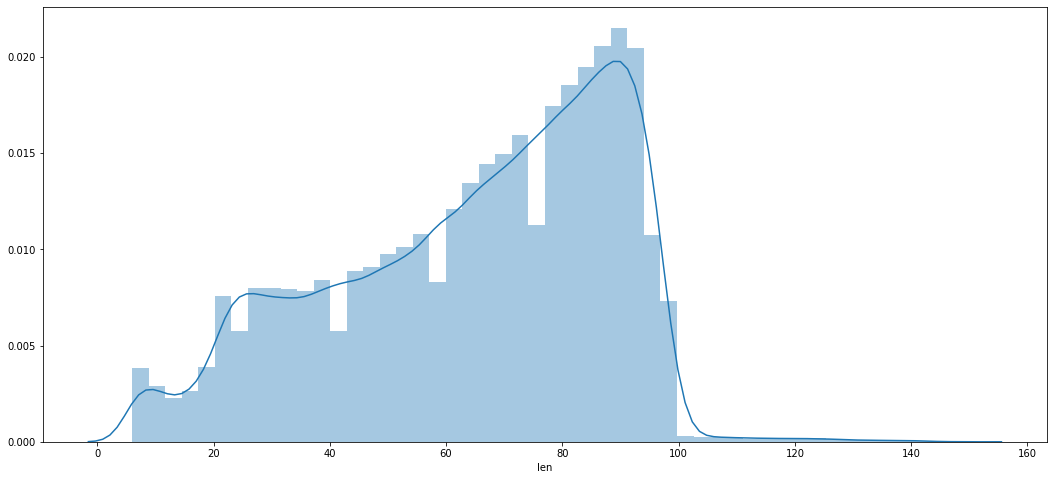

In [120]:
dt['text'] = dt['text'].apply(lambda x: preprocess_text(x))

dt['len'] = dt['text'].apply(lambda x: len(x.split(' ')))
dt = dt.where(dt['len'] > 5)
dt = dt.dropna()

plt.figure(figsize = (18,8))
sns.distplot(dt['len'])

In [121]:
X = dt['text'].values
Y = dt['label'].values

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.1, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    X, Y, stratify=Y, test_size=0.25, random_state=42)

x_train.shape, x_test.shape, x_val.shape

((81217,), (10829,), (27073,))

# Log Reg

In [26]:
log_reg_model_char = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression())
])

log_reg_model_char.fit(x_train, y_train)
preds = log_reg_model_char.predict(x_test)

print('F1-score = {:.2%}'.format(f1_score(y_test, preds)))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, preds))

F1-score = 100.00%
Confusion Matrix: 
[[5256    0]
 [   0 5573]]


In [36]:
t = '«Позиция НАТО является четкой. Мы делаем все, 12 чтобы наши граждане были в безопасности.'
print(f'Predict model on char: {predict_once(log_reg_model_char, t)}')

Predict model on char: [1.]


In [34]:
t = 'Глыбокае навучанне' # белорусский
predict_once(log_reg_model_char, t)

array([1.])

In [37]:
t = 'теперь siri можно попросить исполнить битбокс слова boots and cats которые произносит голосовой помощник являются базовыми для тех кто решил научиться этому искусству'
predict_once(log_reg_model_char, t)

array([1.])

найдем, где наша модель ошибается

In [38]:
find_error(log_reg_model_char, x_test, y_test)

[]

## Уменьшаем обучающих данных

Я обучал на 81217 примерах для logreg, это очень много, попробую уменьшить кол-во данных и добавить регуляризацию

In [122]:
log_reg_model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression(C=10))
])

log_reg_model.fit(x_val, y_val)
preds = log_reg_model.predict(x_test)

print('F1-score = {:.2%}'.format(f1_score(y_test, preds)))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, preds))

F1-score = 100.00%
Confusion Matrix: 
[[5256    0]
 [   0 5573]]


Попробуем сделать предсказания для разных языков:

In [123]:
t = '深い学習' # японский
predict_once(log_reg_model, t)

array([0.])

In [124]:
t = 'Глыбокае навучанне' # белорусский
predict_once(log_reg_model, t)

array([1.])

In [125]:
t = 'Глибоке навчання' # украинский
predict_once(log_reg_model, t)

array([1.])

In [126]:
t = 'I do deep learning, but often everything can be solved using machine learning.' # Английский
predict_once(log_reg_model, t)

array([0.])

In [127]:
t = 'אני לומד עמוק, אבל לעתים קרובות הכל ניתן לפתור באמצעות למידה במכונה.' # Иврит
predict_once(log_reg_model, t)

array([0.])

In [128]:
t = 'дълбокото обучение навлиза в живота ни на големи стъпки, не може да не се радва' # Болгарский
predict_once(log_reg_model, t)

array([1.])

## Организуем поиск по папка

In [181]:
import glob, os
result = {}
os.chdir("/Users/danildmitriev/Desktop/DataScience/abbyy/test/data")
for file in glob.glob("*.txt"):
    with open(file) as f:
        lines = f.readlines()
        predict = [predict_once(model, line.strip()) for line in lines]
        predict = 1 if np.mean(predict) > 0 else 0
        result.update({file:predict})

In [176]:
file_name = [key for key, _ in result.items()]
file_result = [value for _, value in result.items()]

dataframe = pd.DataFrame({'filename':file_name,
                         'answer':file_result})
dataframe.head()

,filename,answer
0,1735.txt,0
1,2228.txt,0
2,1721.txt,1
3,1047.txt,0
4,2566.txt,1


In [ ]:
dataframe.to_csv('prediction.csv')

Функция, которая требовалась в задание

In [179]:
def predict(path, model):
    result = {}
    os.chdir(path)
    for file in glob.glob("*.txt"):
        with open(file) as f:
            lines = f.readlines()
            predict = [predict_once(model, line.strip()) for line in lines]
            predict = 1 if np.mean(predict) > 0 else 0
            result.update({file:predict})
        
    file_name = [key for key, _ in result.items()]
    file_result = [value for _, value in result.items()]

    dataframe = pd.DataFrame({'filename':file_name,
                         'answer':file_result})
    
    dataframe.to_csv('prediction.csv')
    

predict(path = "/Users/danildmitriev/Desktop/DataScience/abbyy/test/data")  
    

# Подготовка данных к Deep Learning

Я понимаю, что кто тут не нужен, так это глубокое обучение, но интересно попробовать. 

In [ ]:
train_df = [(x_train[i], y_train[i]) for i in range(len(x_train))]
valid_df = [(x_val[i], y_val[i]) for i in range(len(x_val))]
test_df = [(x_test[i], y_test[i]) for i in range(len(x_test))]

In [ ]:
TEXT = Field(batch_first=True)
LABEL = LabelField(dtype = torch.float)

fields = [('text',TEXT), ('label',LABEL)]

train_dataset = Dataset([Example.fromlist(example, fields) for example in train_df], fields)
val_dataset = Dataset([Example.fromlist(example, fields) for example in valid_df], fields)
test_dataset = Dataset([Example.fromlist(example, fields) for example in test_df], fields)

In [ ]:
MAX_VOCAB_SIZE = 50000

TEXT.build_vocab(train_dataset, 
                 max_size = MAX_VOCAB_SIZE)

LABEL.build_vocab(train_dataset)

print('Vocab size =', len(TEXT.vocab))
print('Label count =', len(LABEL.vocab))

Vocab size = 50002
Label count = 2


In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, val_dataset, test_dataset), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    device = device)

# Bidirectional - GRU

In [ ]:
class GRUBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, n_layers=1, dropout=0.1, bidirectional=False):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, n_layers, bidirectional=bidirectional)
        self.linear = nn.Linear((1 + bidirectional) * n_layers * hidden_dim, 1)

        self.dropout = nn.Dropout(0.1)
        
    def forward(self, seq):
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        _, hidden = self.gru(emb)
        hidden = torch.cat([x_0 for x_0 in hidden], -1)
        hidden = self.dropout(hidden)
        output = self.linear(hidden).squeeze(-1)
        output = torch.sigmoid(output)

        return output

[1 / 3] Train: Average Loss = 0.51408, F1-score = 72.894%: 100%|██████████| 3183/3183 [03:10<00:00, 16.72it/s]
[1 / 3]   Val: Average Loss = 0.50681, F1-score = 84.590%: 100%|██████████| 354/354 [00:05<00:00, 68.71it/s]
[2 / 3] Train: Average Loss = 0.50692, F1-score = 94.207%: 100%|██████████| 3183/3183 [03:09<00:00, 16.77it/s]
[2 / 3]   Val: Average Loss = 0.50641, F1-score = 96.451%: 100%|██████████| 354/354 [00:05<00:00, 70.34it/s]
[3 / 3] Train: Average Loss = 0.50648, F1-score = 98.282%: 100%|██████████| 3183/3183 [03:09<00:00, 16.76it/s]
[3 / 3]   Val: Average Loss = 0.50687, F1-score = 99.356%: 100%|██████████| 354/354 [00:05<00:00, 67.79it/s]


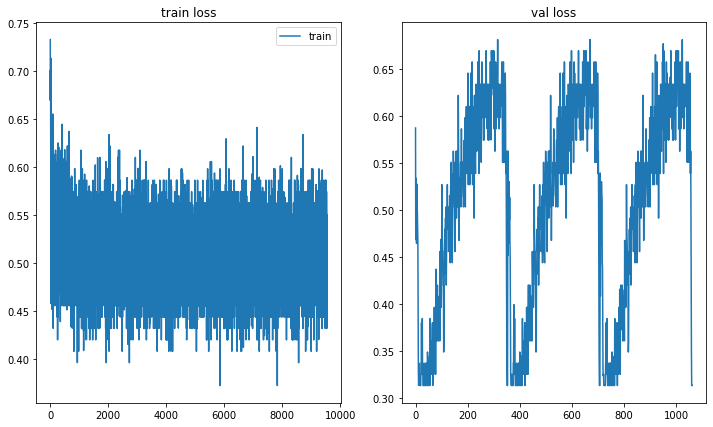

In [ ]:
hidden_dim = 128
emb_dim = 100
model = GRUBaseline(hidden_dim, emb_dim, n_layers=2, bidirectional=True).to(device)
EPOCHS = 3

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)
fit(model, criterion, optimizer, train_data=train_iterator,
    epochs_count=EPOCHS, val_data=valid_iterator)

# CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, emb_dim, kernel_sizes, dropout=0.2, n_filters=100):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (ks, emb_dim)) 
                                    for ks in kernel_sizes
                                    ])

        self.linear = nn.Linear(len(kernel_sizes) * n_filters, 1)

        self.dropout = nn.Dropout(dropout)

        
    def forward(self, x):
        emb = self.embedding(x).unsqueeze(1)
        conved = [F.relu(conv(emb)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.linear(cat).squeeze(-1)
        output = torch.sigmoid(output)
        
        return output


[1 / 3] Train: Average Loss = 0.51699, F1-score = 67.161%: 100%|██████████| 764/764 [08:55<00:00,  1.43it/s]
[1 / 3]   Val: Average Loss = 0.50820, F1-score = 71.628%: 100%|██████████| 85/85 [00:03<00:00, 24.33it/s]
[2 / 3] Train: Average Loss = 0.50829, F1-score = 80.594%: 100%|██████████| 764/764 [08:53<00:00,  1.43it/s]
[2 / 3]   Val: Average Loss = 0.50806, F1-score = 85.489%: 100%|██████████| 85/85 [00:03<00:00, 24.58it/s]
[3 / 3] Train: Average Loss = 0.50819, F1-score = 86.961%: 100%|██████████| 764/764 [08:57<00:00,  1.42it/s]
[3 / 3]   Val: Average Loss = 0.50803, F1-score = 87.662%: 100%|██████████| 85/85 [00:03<00:00, 27.98it/s]


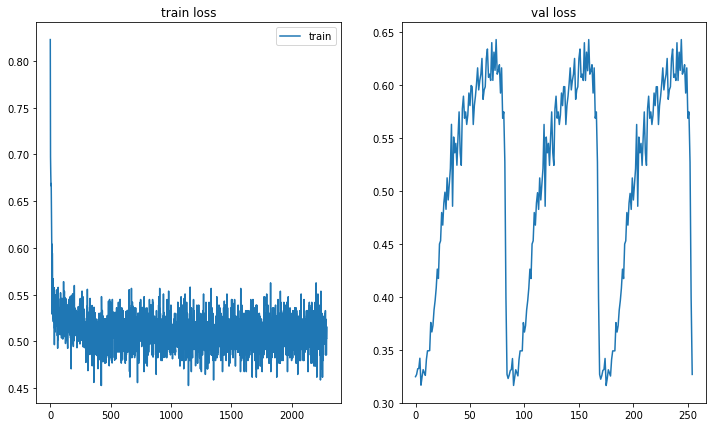

In [ ]:
emb_dim = 100
kernel_sizes = [2, 3, 4, 5]

model = CNN(emb_dim, kernel_sizes).to(device)
EPOCHS = 3

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss().to(device)
fit(model, criterion, optimizer, train_data=train_iterator,
    epochs_count=EPOCHS, val_data=valid_iterator)

# BERT-BiGRU

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
train_data = {'sentence':[i[0] for i in train_df],
              'label':[i[1] for i in train_df]}

val_data = {'sentence':[i[0] for i in valid_df],
              'label':[i[1] for i in valid_df]}

test_data = {'sentence':[i[0] for i in test_df],
              'label':[i[1] for i in test_df]}

In [ ]:
BATCH_SIZE = 8
MAX_LEN = 150

train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
class BERT_biGRU(nn.Module):
    def __init__(self, hidden_dim=256, bidirectional=True, num_layers=1):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

        self.rnn = nn.GRU(768, hidden_dim, bidirectional=bidirectional,
                      num_layers=num_layers, batch_first=True,
                      dropout = 0 if num_layers < 2 else 0.1)
    
        self.drop = nn.Dropout(p=0.1)
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
  
    def forward(self, inputs):
        input_ids = inputs[0]
        attention_mask = inputs[1]

        bert_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )[0]

        output = self.drop(bert_output)

        _, hidden = self.rnn(output)

        output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.linear(output).squeeze(1)

        return output

In [ ]:
hidden_dim = 128
model = BERT_biGRU(hidden_dim)
model = model.to(device)

EPOCHS = 1

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss().to(device)
a = do_epoch(model, criterion, test_data_loader, optimizer, bert=True)

      Average Loss = 0.00985, F1-score = 99.055%: 100%|██████████| 1415/1415 [10:11<00:00,  2.31it/s]


In [ ]:
a = do_epoch(model, criterion, val_data_loader, bert=True)

      Average Loss = 0.00347, F1-score = 99.538%: 100%|██████████| 3537/3537 [05:55<00:00,  9.95it/s]


In [ ]:
t = 'Глибоке навчання' # украинский
predict_bert(model, t)

1.0

In [ ]:
t = 'Text classification is the automatic process of predicting one or more categories given a piece of text.' # английский
predict_bert(model, t)

0.0

Ошибка со слованскими языками не прошла

Что там с LogReg, попробуем обучить на тех же данных, что и BERT:

In [ ]:
log_reg_model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
    ('log_regression', LogisticRegression())
])

log_reg_model.fit(x_test, y_test)
preds = log_reg_model.predict(x_val)

print('F1-score = {:.2%}'.format(f1_score(y_val, preds)))
print('Confusion Matrix: ')
print(confusion_matrix(y_val, preds))

F1-score = 99.87%
Confusion Matrix: 
[[14002    15]
 [   23 14252]]


Эх, думал, что bert успешно сможет в FewShot learning, он смог, но logreg тоже красава